In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from utilities import threshold, data

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

## Load predictions

In [3]:
dlcst_preds = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [4]:
dlcst_democols = {
    'cat': ['Sex', 'FamilyHistoryLungCa', 'Emphysema'],
    'num': ['Age', 'NoduleCountPerScan']
}

In [5]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

## Pick threshold policies

In [8]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

policy_threshold_df, perfs = threshold.get_threshold_policies(dlcst_preds, models=MODEL_TO_COL, policies=policies, brock=True)
policy_threshold_df

,Sensitivity=0.9,Specificity=0.9,Brock
Venkadesh,0.113,0.323,0.06
de Haas,0.168,0.360,0.06
Sybil,0.001,0.018,0.06
PanCan2b,0.020,0.093,0.06


Save thresholds.

In [9]:
policy_threshold_df['col'] = policy_threshold_df.apply(lambda x: MODEL_TO_COL[x.name], axis=1)
policy_threshold_df.to_csv(f"{DLCST_PREDS}/policy-thresholds-{len(dlcst_preds)}.csv", index=True)
policy_threshold_df.drop(columns=['col'], inplace=True)

## Plot results by category

In [10]:
def plot_by_category(df, cat, metrics_to_plot=['fpr', 'fnr'], diff=True):
    display(Markdown(f"### {cat}"))
    stats = threshold.plot_threshold_stats_subgroups(
        df, cat, policy_threshold_df,
        dataset_name='DLCST',
        models=MODEL_TO_COL,
        plot_metrics=metrics_to_plot,
        diff=diff, show_all=False,
        min_mal=10,
    )

### Categorical columns

### Sex

,num,pct,mal,ben,pct_mal
1,323,53.923205,32,291,9.907121
2,276,46.076795,27,249,9.782609


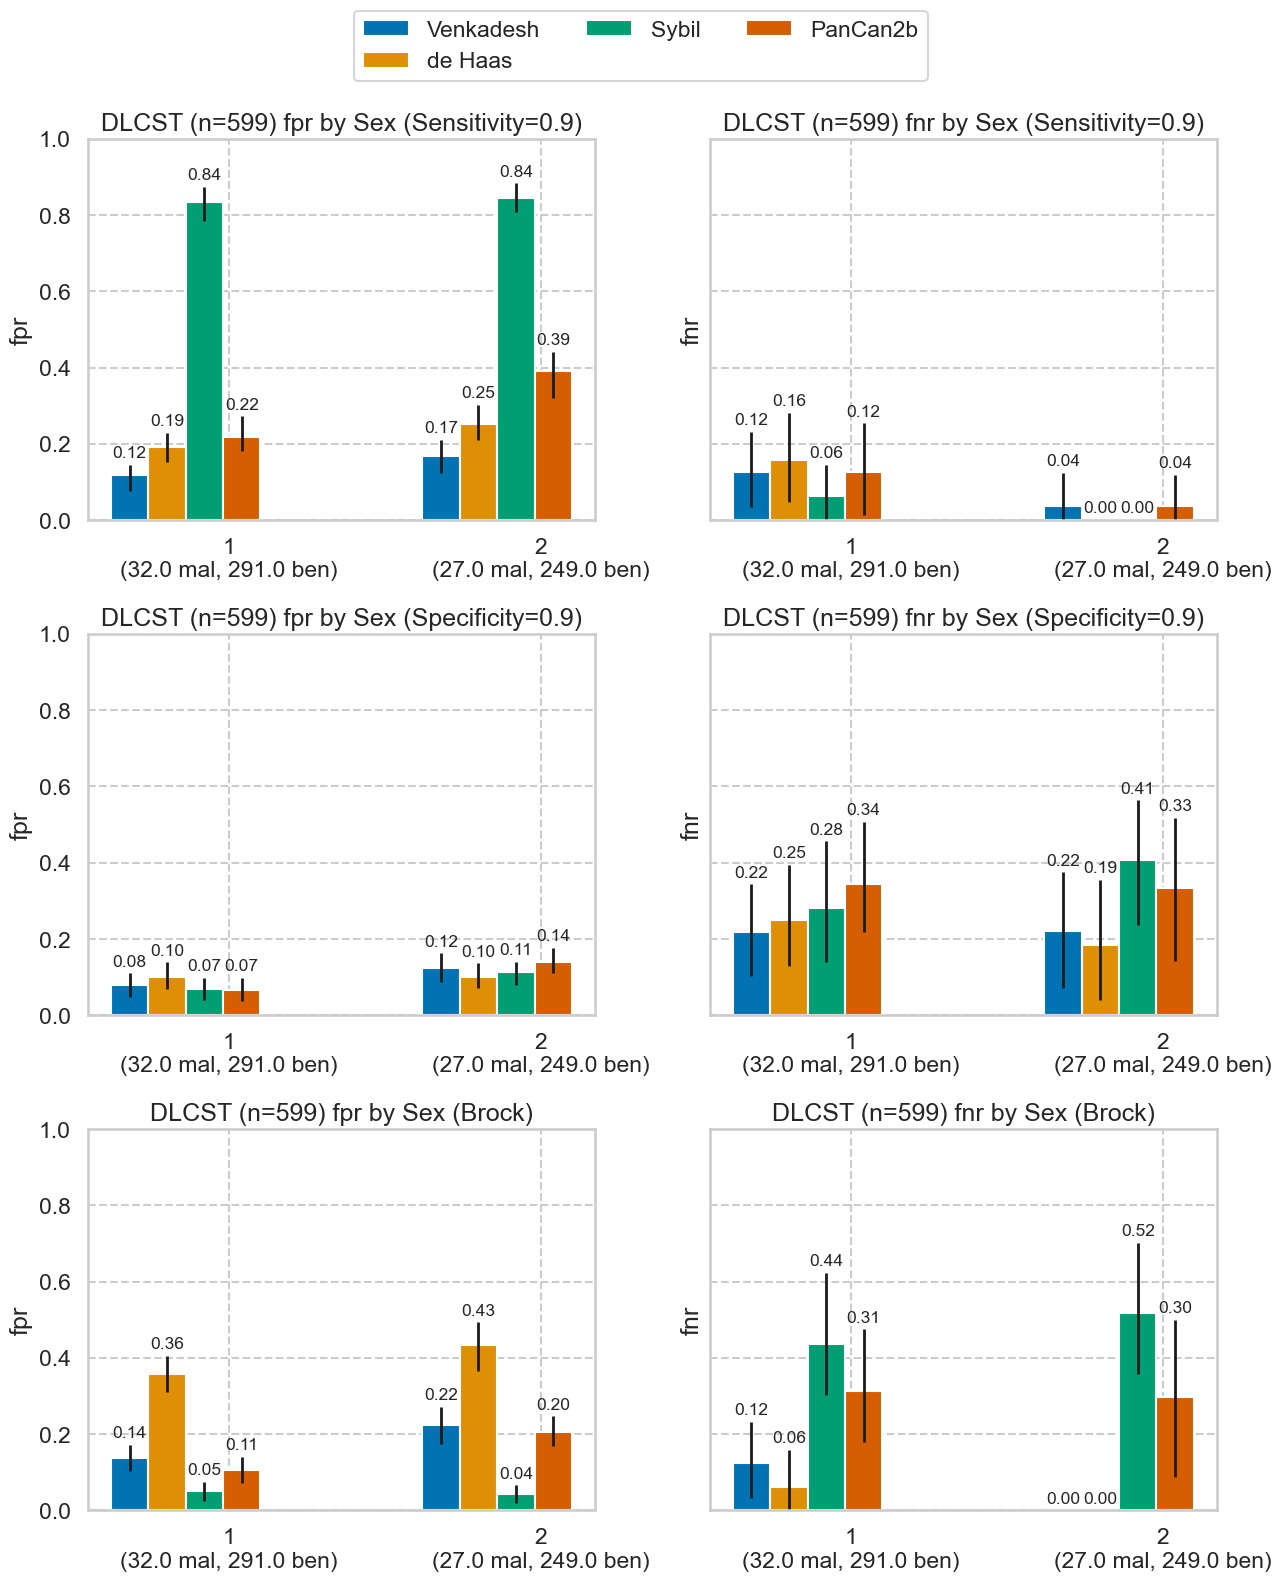

### FamilyHistoryLungCa

,num,pct,mal,ben,pct_mal
0,497,82.971619,43,454,8.651911
1,102,17.028381,16,86,15.686275


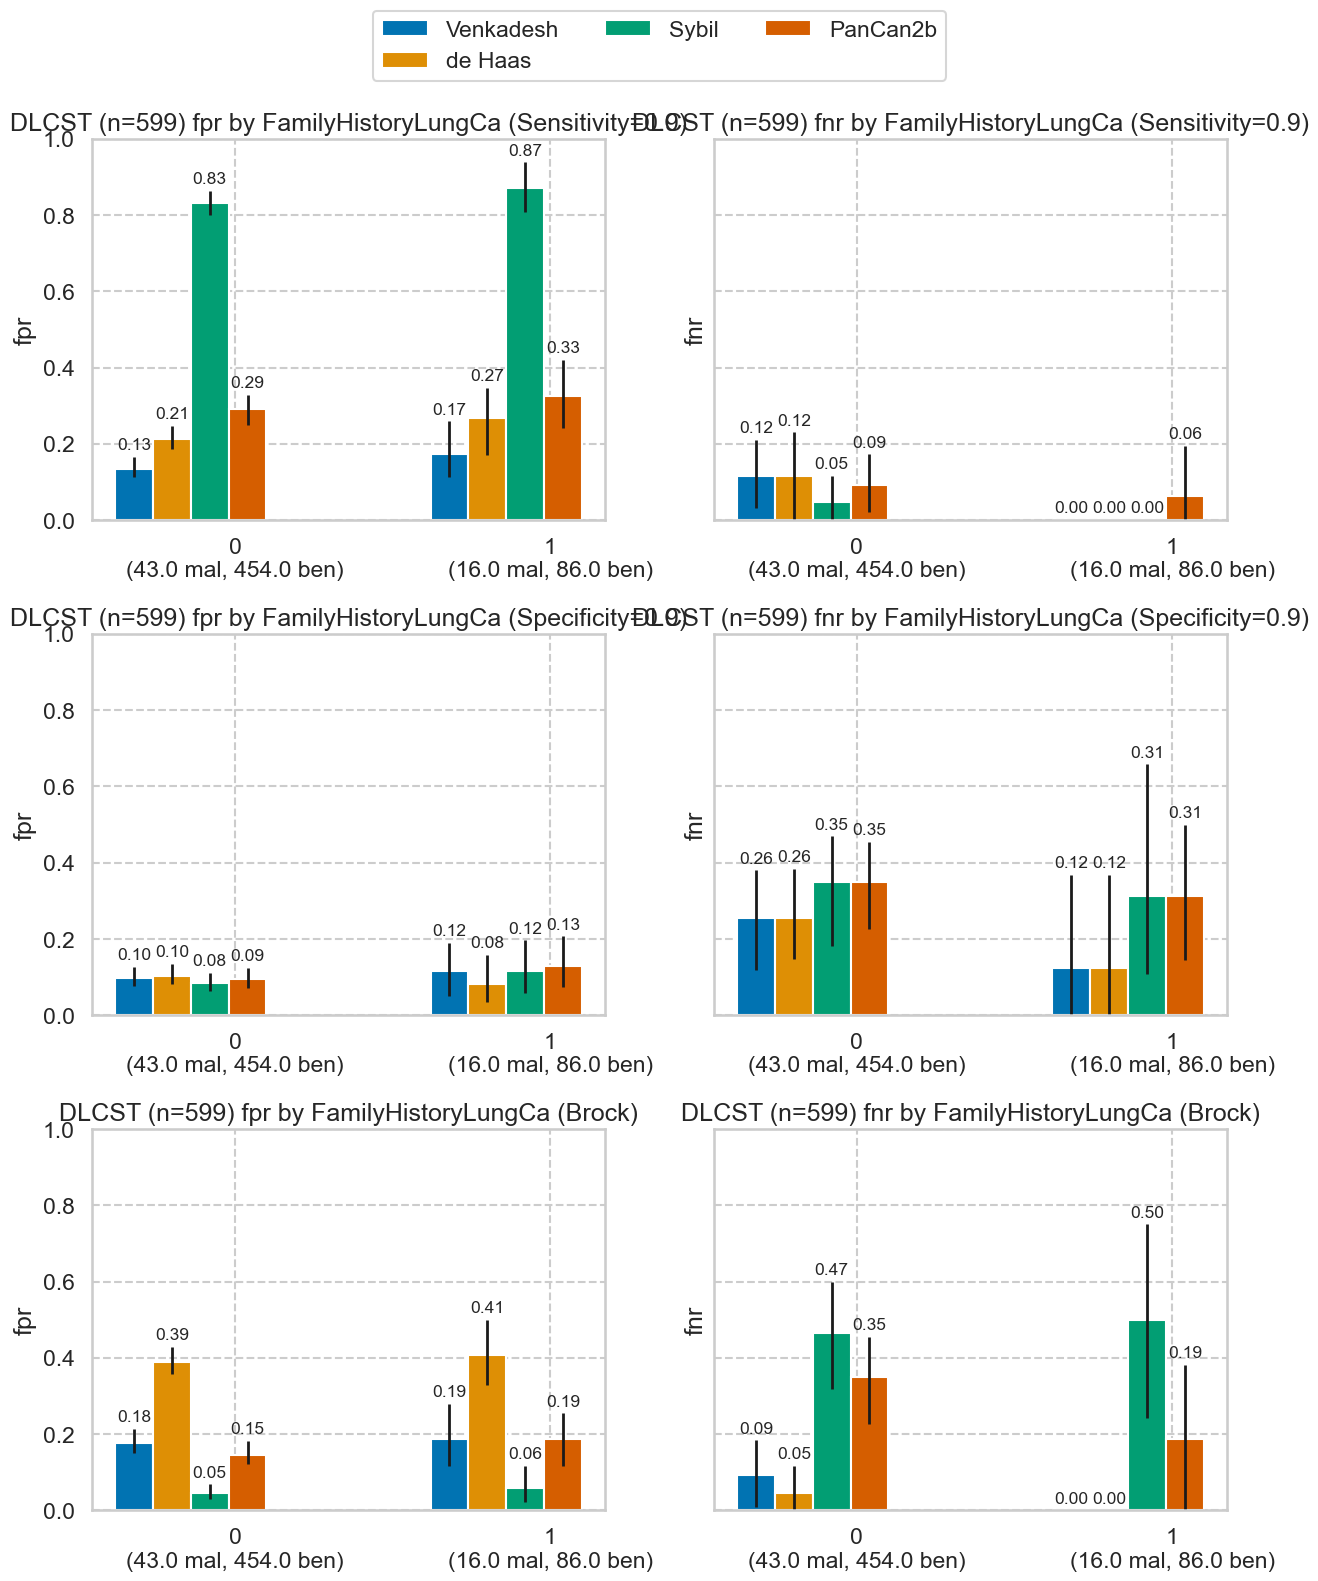

### Emphysema

,num,pct,mal,ben,pct_mal
0,194,32.387312,15,179,7.731959
1,405,67.612688,44,361,10.864198


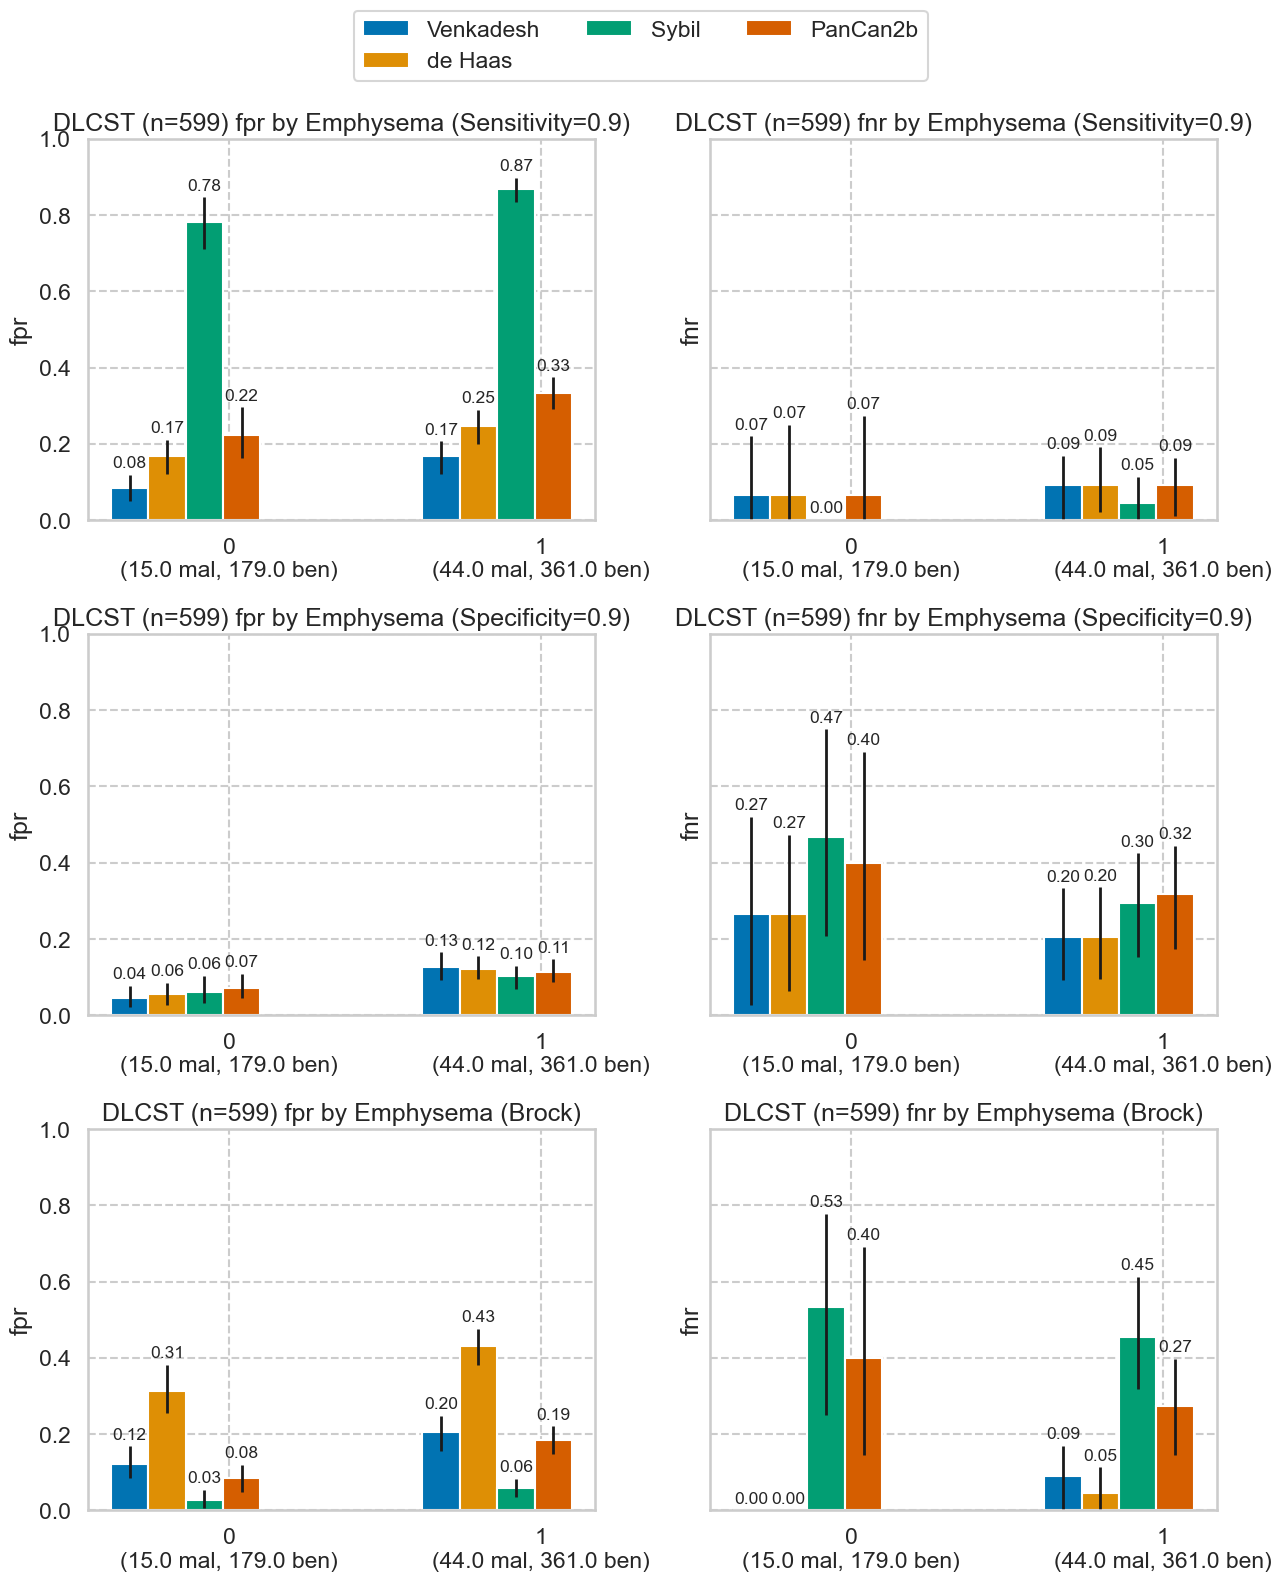

In [11]:
for c in dlcst_democols['cat']:
    plot_by_category(dlcst_preds, c, diff=False)

### Numerical columns

C:\Users\shaur\AppData\Local\Temp\ipykernel_16604\66219517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(dlcst_preds.groupby(f'bin_Age')[['label', f'Age']].describe())


label                                                 Age  \
          count      mean       std  min  25%  50%  75%  max  count   
bin_Age                                                               
(50, 61]  414.0  0.067633  0.251419  0.0  0.0  0.0  0.0  1.0  414.0   
(61, 80]  164.0  0.189024  0.392727  0.0  0.0  0.0  0.0  1.0  164.0   

                                                              
               mean       std   min    25%   50%   75%   max  
bin_Age                                                       
(50, 61]  56.367150  3.195106  51.0  53.25  56.0  59.0  61.0  
(61, 80]  64.597561  2.377604  62.0  63.00  64.0  66.0  75.0

### bin_Age

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(cat)


,num,pct,mal,ben,pct_mal
"(50, 61]",414,69.115192,28,386,6.763285
"(61, 80]",164,27.378965,31,133,18.902439


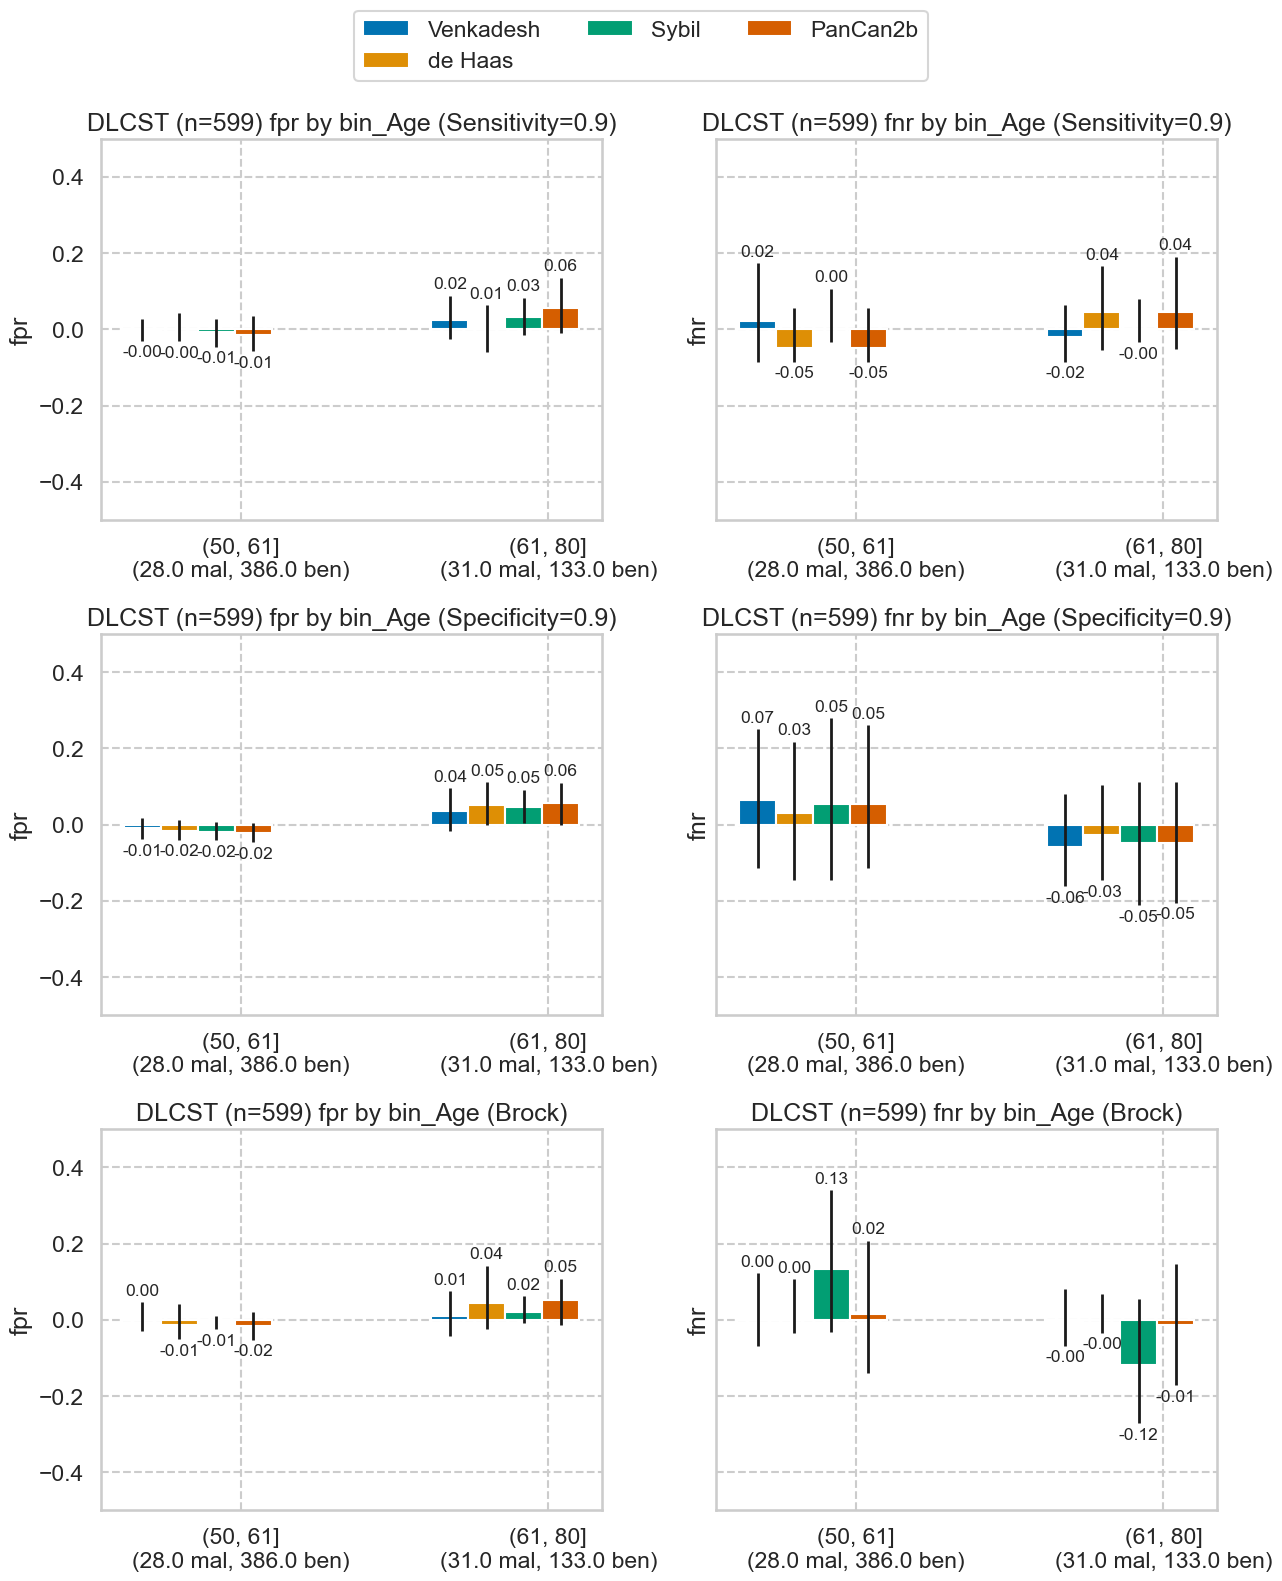

In [12]:
dlcst_preds['bin_Age'] = pd.cut(dlcst_preds['Age'], bins=[50, 61, 80], right=True)
display(dlcst_preds.groupby(f'bin_Age')[['label', f'Age']].describe())
plot_by_category(dlcst_preds, f'bin_Age')

C:\Users\shaur\AppData\Local\Temp\ipykernel_16604\1921029532.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(dlcst_preds.groupby(f'bin_NoduleCountPerScan')[['label', f'NoduleCountPerScan']].describe())


label                                               \
                        count      mean       std  min  25%  50%  75%  max   
bin_NoduleCountPerScan                                                       
(0, 1]                  333.0  0.105105  0.307150  0.0  0.0  0.0  0.0  1.0   
(1, 12]                 266.0  0.090226  0.287045  0.0  0.0  0.0  0.0  1.0   

                       NoduleCountPerScan                                     \
                                    count      mean       std  min  25%  50%   
bin_NoduleCountPerScan                                                         
(0, 1]                              333.0  1.000000  0.000000  1.0  1.0  1.0   
(1, 12]                             266.0  2.733083  1.178501  2.0  2.0  2.0   

                                  
                        75%  max  
bin_NoduleCountPerScan            
(0, 1]                  1.0  1.0  
(1, 12]                 3.0  9.0

### bin_NoduleCountPerScan

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(cat)


,num,pct,mal,ben,pct_mal
"(0, 1]",333,55.592654,35,298,10.510511
"(1, 12]",266,44.407346,24,242,9.022556


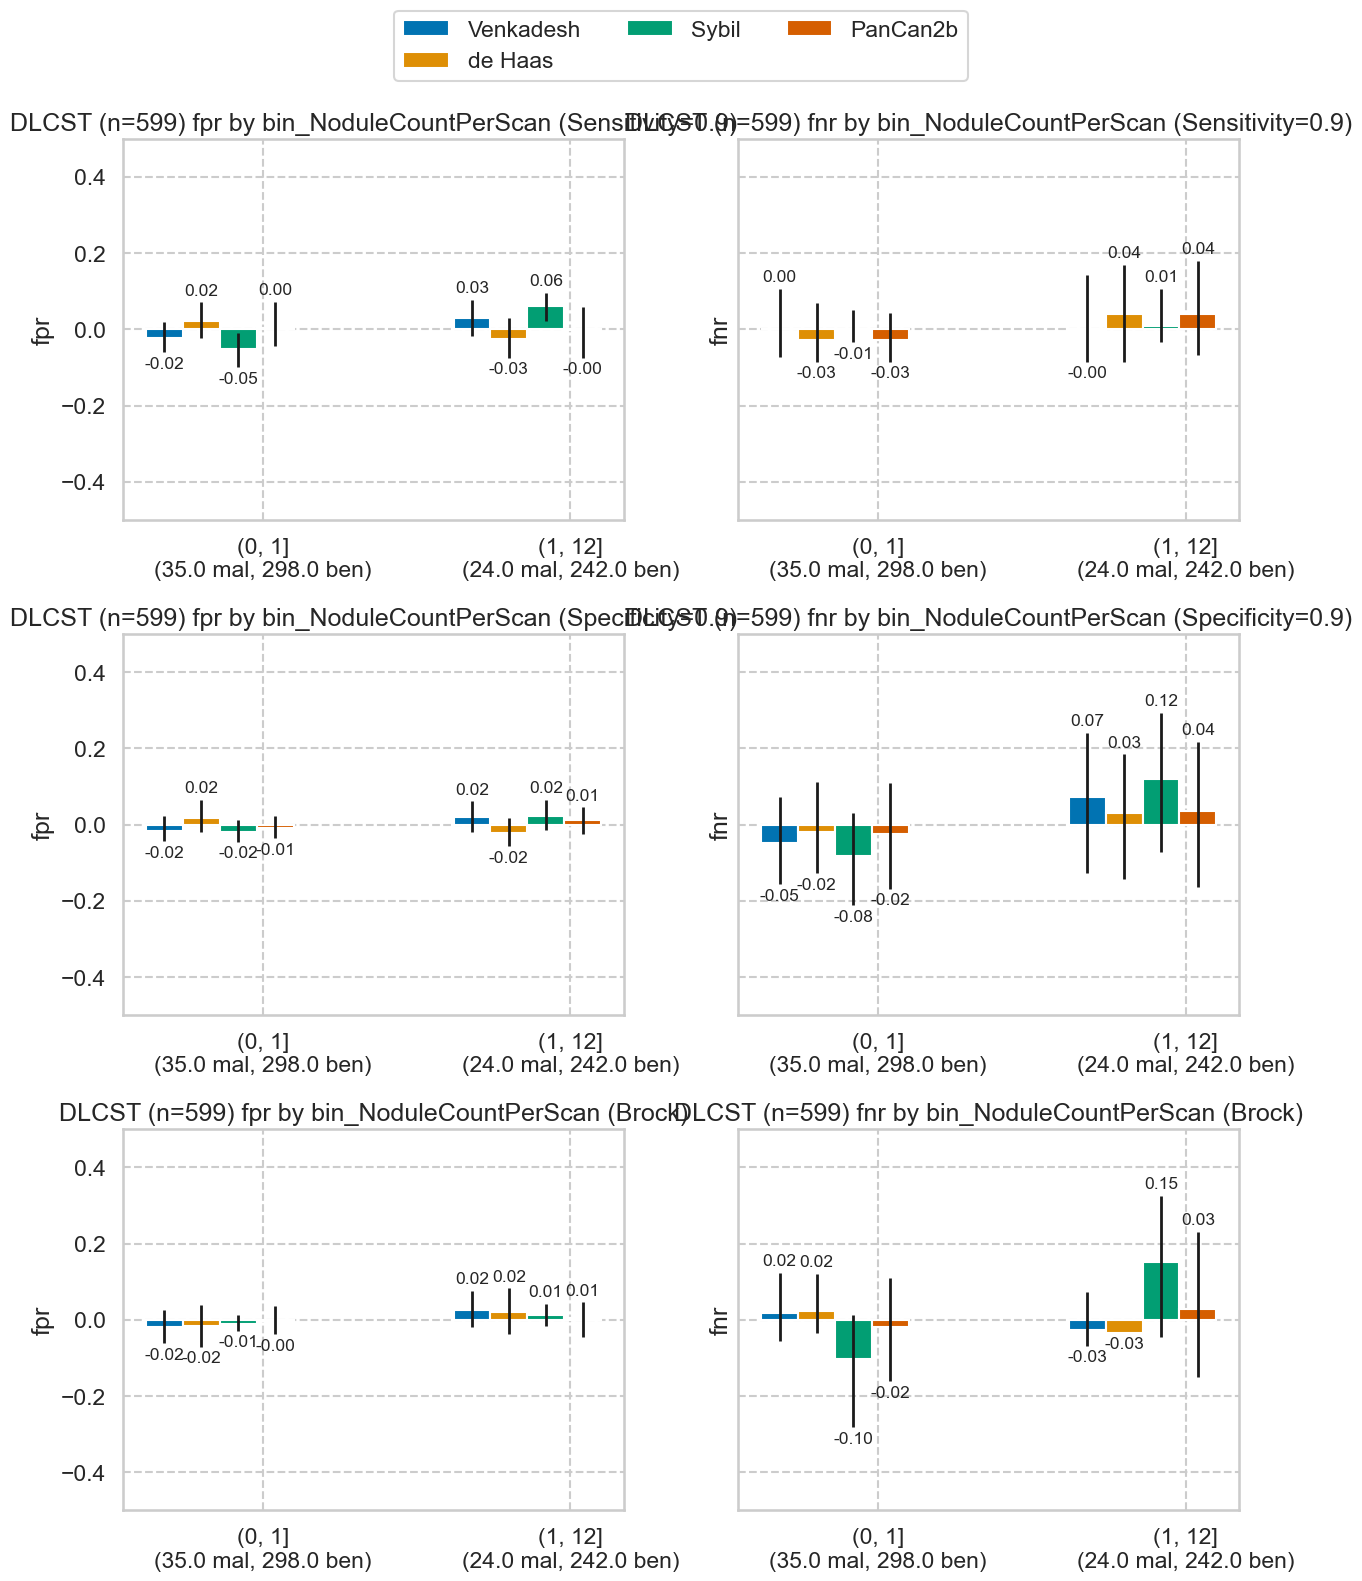

In [13]:
dlcst_preds['bin_NoduleCountPerScan'] = pd.cut(dlcst_preds['NoduleCountPerScan'], bins=[0, 1, 12], right=True)
display(dlcst_preds.groupby(f'bin_NoduleCountPerScan')[['label', f'NoduleCountPerScan']].describe())
plot_by_category(dlcst_preds, f'bin_NoduleCountPerScan')